<a href="https://colab.research.google.com/github/PetrisorMarcelin/ContiRepo/blob/master/P1_week2_fitting_lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 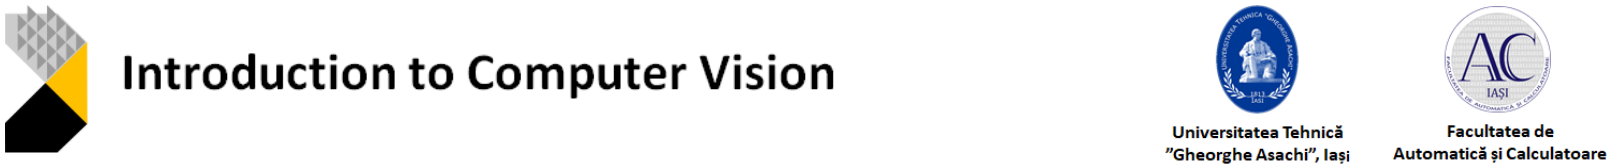

  The 2022 Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs. 
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 1: Lane Detection

In the field of Computer Vision, extraction of geometric features from images is a common problem. Different approaches have been proven to be efficient in extracting particular features as part of the solution. Some solutions involve global examination of the input image, while others involve local examination at pixel level. A basic feature of any self-driving system is Lane Detection.




## Week 2: fitting lines using Hough Transform

Q: Wait, why aren’t we done just by running Canny edge detection?

A: Because we only have edges, for the desired result we need to define the function which turns these edges into lines.

###Questions when fitting lines:
1. Given points that belong to a line, what is the line?
2. How many lines are there?
3. Which points belong to which lines?

Hough Transform is a voting technique that can be used to answer all of these.

###From Image space to Hough Space:
1. A line in the image corresponds to a point in Hough space.
2. To go from image space to Hough space:
> Given a set of points (x,y), find all (m,b) such that y = m*x + b
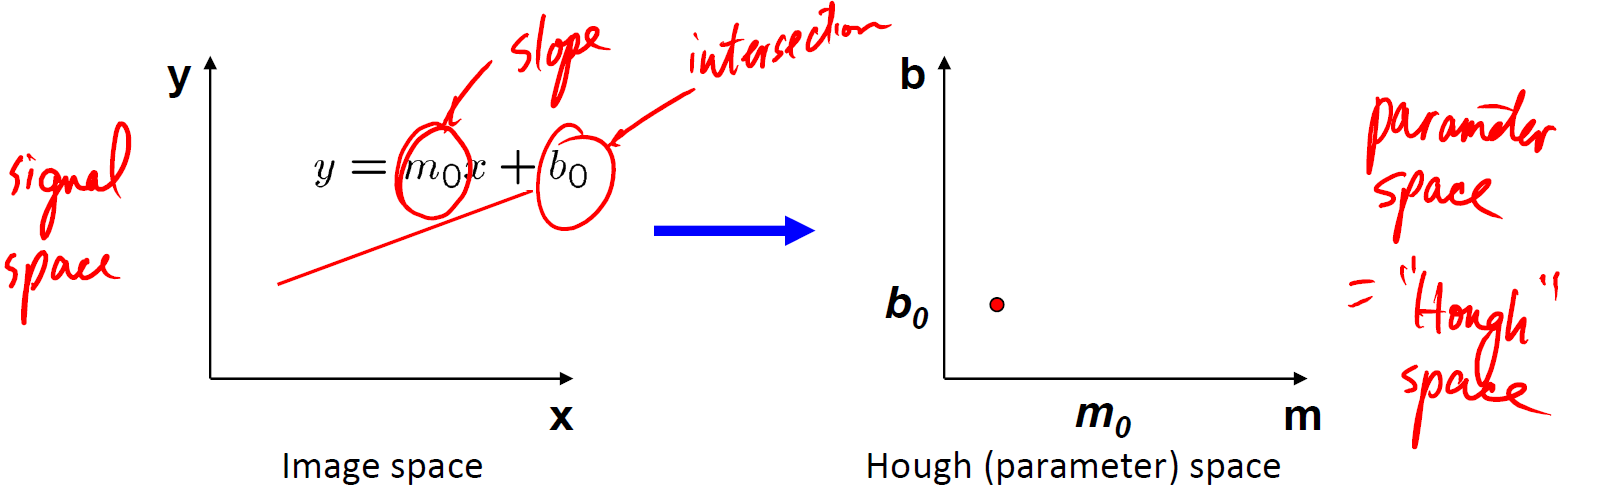
3. Q: What does a point (x0, y0) in the image space map to?
> A: the solutions of b = -x0m + y0. This is **a line in Hough space**.
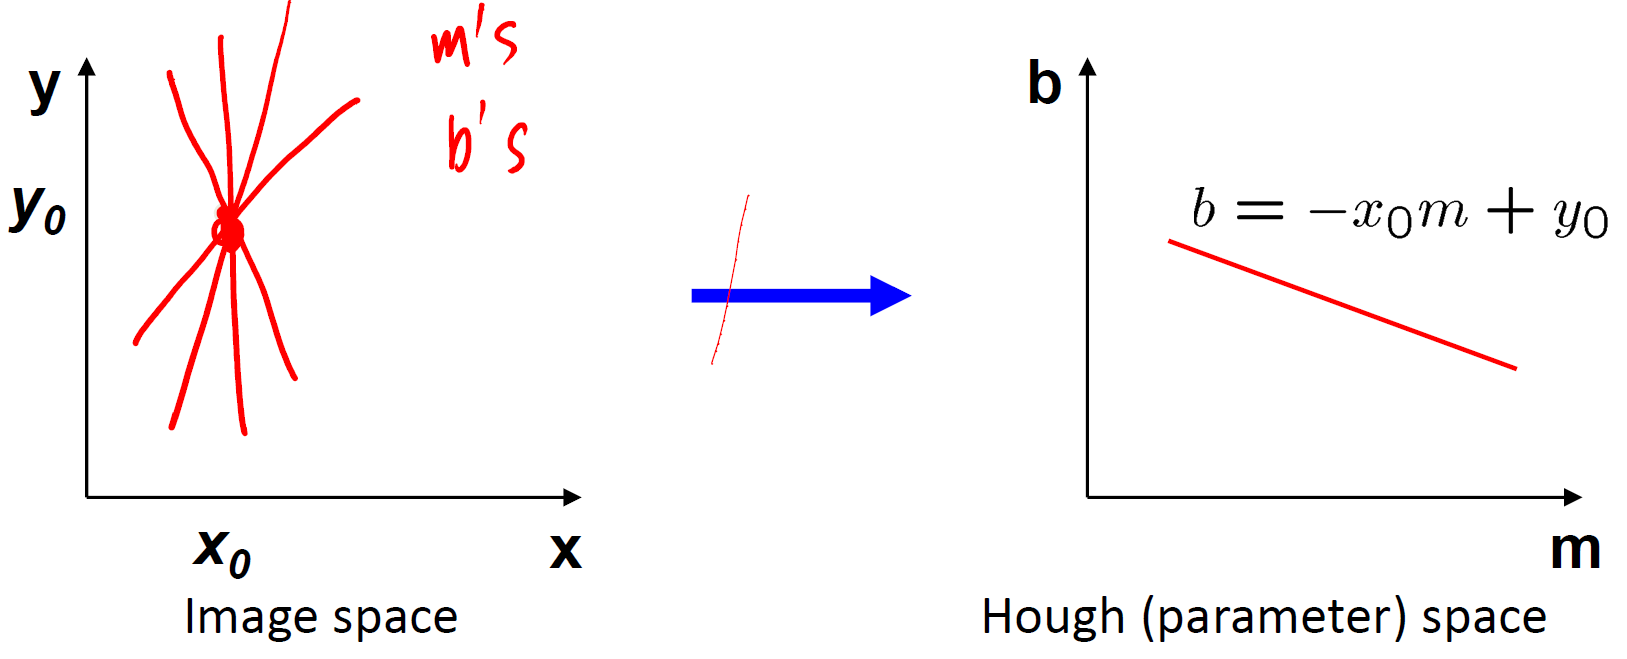
4. Q: What are the line parameters for the line that contains both (x0, y0) and (x1, y1)?
> A: It is the intersection of the lines b = –x0m + y0 and b = –x1m + y1
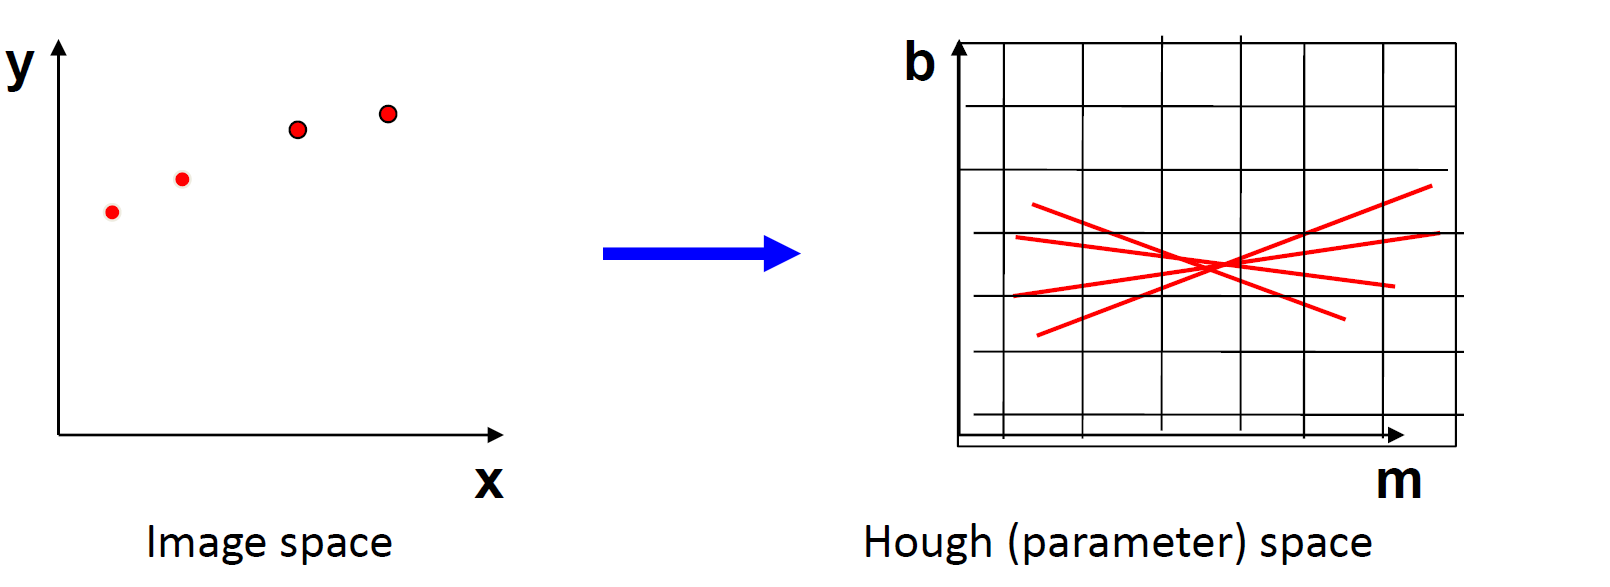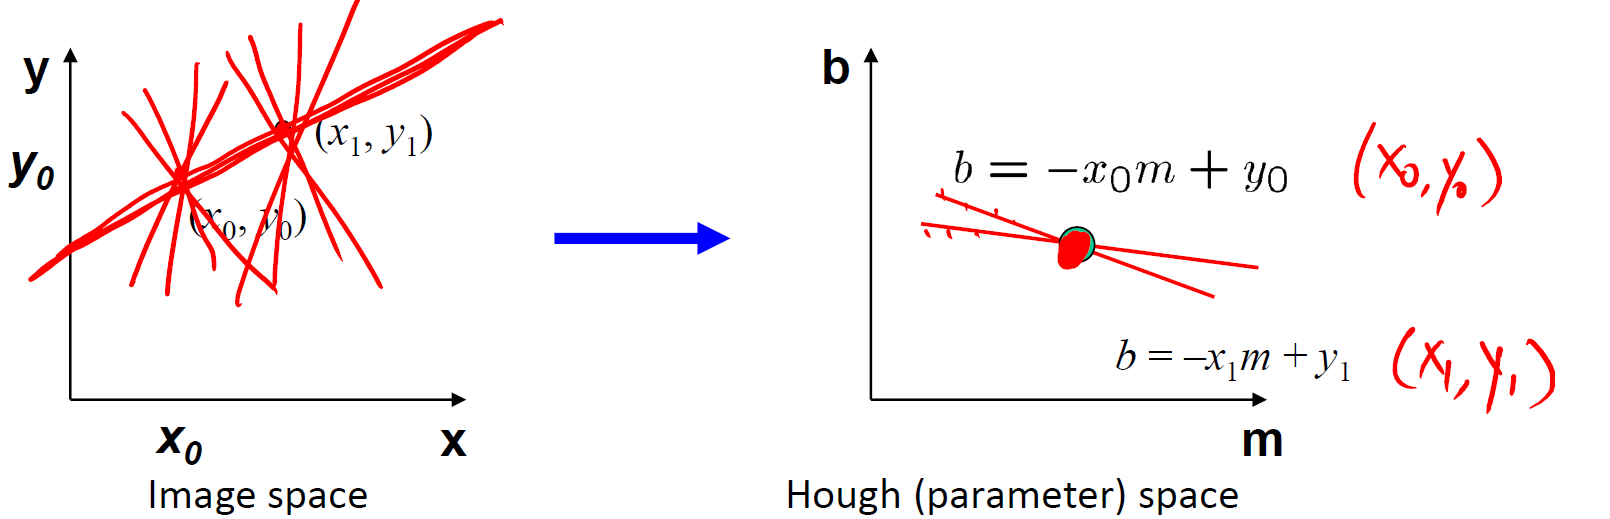

###Hough Transform a voting technique:
1. Record all possible lines on which each edge point lies.
2. Look for lines that get many votes.
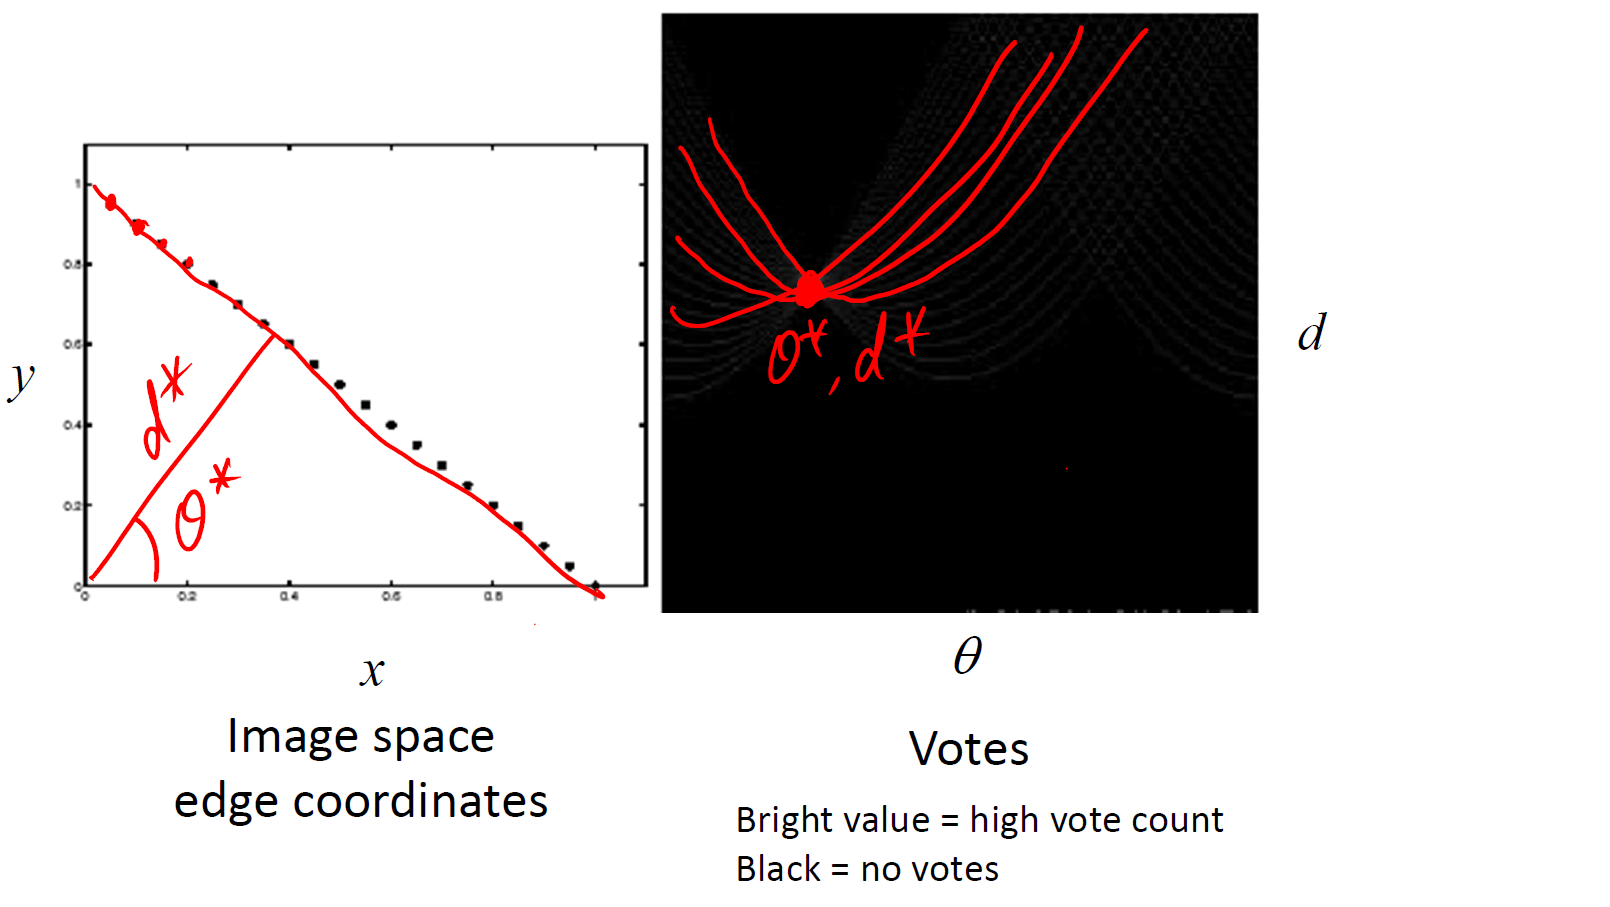

In [1]:
#TODO: go to 1st demo at https://www.aber.ac.uk/~dcswww/Dept/Teaching/CourseNotes/current/CS34110/hough.html and draw parallel lines/rectangle and inspect detected lines and Hough Transform
#TODO: go to 2nd demo at http://dersmon.github.io/HoughTransformationDemo/ and test rectangle & circle images with different thresholds

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#TODO add image at https://drive.google.com/file/d/1Ex-H9C-MGRb2hd2L1flV_A-xevPX9wjA/view?usp=sharing to My Drive

In [84]:
#check if image is in Drive
!ls "/content/drive/My Drive/test.jpeg"

'/content/drive/My Drive/test.jpeg'


In [85]:
#last week's functions (grayscale, gaussian_smoothing, canny_detector, region_of_interest, overlap, our_pipeline)

def grayscale(img):
  #code here
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return gray

# 2. gaussian smoothing
def gaussian_smoothing(img, kernel_size):
  #code here
  smoothed_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
  return smoothed_img

# 3. Canny edge detection
def canny_detector(img, low_threshold, high_threshold):
  #code here
  canny_edges = cv2.Canny(img, low_threshold, high_threshold)
  return canny_edges

# 4. Region of Interest: define vertices, create the mask (trapeze), apply the mask to Canny edges
def region_of_interest(img):
  #code here
  rows, cols = img.shape[:2]

  bottom_left  = [0.25*cols, rows]
  top_left     = [cols*0.48, rows*0.55]
  bottom_right = [0.75*cols, rows]
  top_right    = [cols*0.52, rows*0.55]
  '''
  bottom_left  = [0, rows*0.95]
  top_left     = [cols*0.45, rows*0.55]
  bottom_right = [cols, rows]
  top_right    = [cols*0.55, rows*0.55]
  '''
  vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

  # defining a blank mask to start with
  mask = np.zeros_like(img)
  ignore_mask_color = 255  # filling pixels inside the polygon defined by "vertices" with the fill color    
  
  cv2.fillPoly(mask, vertices, ignore_mask_color)
  
  masked_edges = cv2.bitwise_and(img, mask)
  return masked_edges

# 5. Overlap two images
def overlap(img, a, initial_img, b, c):
  #code here
  edges_over_gray = cv2.addWeighted(img, a, initial_img, b, c)
  return edges_over_gray

# 6. our pipeline as a function
def our_pipeline(image):
    #Grayscale
    #code here
    gray_img = grayscale(image)

    #Gaussian Smoothing
    #code here
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    smoothed_img = gaussian_smoothing(gray_img, kernel_size)

    #Canny Edge Detection
    #code here
    #parameters
    low_threshold = 180
    high_threshold = 240
    canny_img = canny_detector(smoothed_img, low_threshold, high_threshold)

    #Masked Image Within a Polygon
    masked_edges = region_of_interest(canny_img)

    #Hough Transform Lines
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 20        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 180    # maximum gap in pixels between connectable line segments
    
    houghed_lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    a = 0.8
    b = 1
    c = 0.    
    output = overlap(houghed_lines, a, image, b, c)

    #Draw lines on input image
    #code here
    edges = cv2.bitwise_not(masked_edges)
    output = overlap(edges, a, gray_img, b, c)

    return output

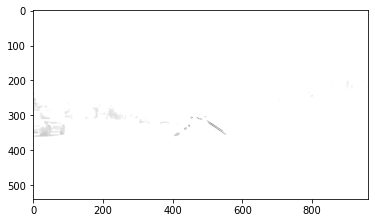

In [93]:
#TODO: read image - see cv2.imread
#code here
image=cv2.imread("/content/drive/My Drive/test.jpeg")

#TODO: BGR to RGB - see cv2.cvtColor(..., cv2.COLOR_BGR2RGB)
#code here
cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

#TODO: apply last week's pipeline on test image
#code here
final_image= our_pipeline(image)


#TODO: print result - see plt.imshow
#code here
plt.imshow(final_image,cmap='gray')

At this point you should be here: 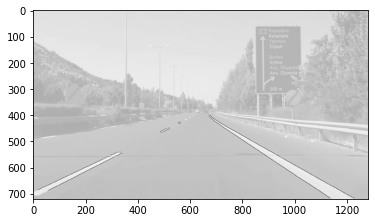

In [94]:
#TODO: Function to draw lines on image
# each line is described by a pair of 2 points 
# parameter lines is a list of (x1, y1, x2, y2)

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            #TODO: draw a line on the image - see cv2.line
            #code here
            start_point=(x1,y1)
            end_point=(x2,y2)
            cv2.line(img,start_point,end_point,color)


In [95]:
#TODO: Function to extract hough lines and draw them on a blank (white) image

# Hough transform parameters 
# rho                  - distance resolution in pixels of the Hough grid
# theta                - angular resolution in radians of the Hough grid
# threshold            - minimum number of votes (intersections in Hough grid cell)
# min_line_length      - minimum number of pixels making up a line
# max_line_gap = 180   - maximum gap in pixels between connectable line segments

def hough_lines(img, rho, theta, threshold, min_line_length, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    #TODO: extract Hough lines - see cv2.HoughLinesP
    #code here 
    linesP=cv2.HoughLinesP(img,rho,theta,threshold,None,min_line_length,max_line_gap)
    
    
    #blank image (on 3 channels) the same size as input image to draw the lines on
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    #TODO: draw lines on the blank image and return - use draw_lines function defined above
    #code here
    draw_lines(line_img,linesP)
    return line_img

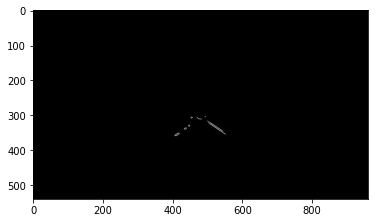

In [96]:
#last week's code until masked Canny edges
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

kernel_size = 5 # Must be an odd number (3, 5, 7...)
smoothed_img = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

low_threshold = 180
high_threshold = 240
canny_edges = cv2.Canny(smoothed_img, low_threshold, high_threshold)

rows, cols = image.shape[:2]
bottom_left  = [0.25*cols, rows]
top_left     = [cols*0.48, rows*0.55]
bottom_right = [0.75*cols, rows]
top_right    = [cols*0.52, rows*0.55]
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

mask = np.zeros_like(gray)
ignore_mask_color = 255
cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_edges = cv2.bitwise_and(canny_edges, mask)

plt.imshow(masked_edges, cmap='gray')


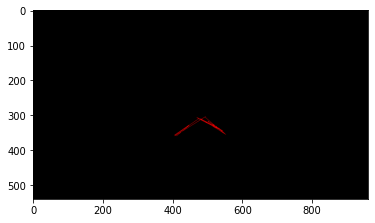

In [102]:
#TODO: Apply hough_lines on last week's masked Canny edges

# recommended Hough transform parameters
rho = 1               # distance resolution in pixels of the Hough grid
theta = np.pi/180     # angular resolution in radians of the Hough grid
threshold = 10        # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20  #minimum number of pixels making up a line
max_line_gap = 180    # maximum gap in pixels between connectable line segments

#code here
hough=hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)

#TODO: print Hough lines - see plt.imshow
#code here
plt.imshow(hough)


At this point you should be here:
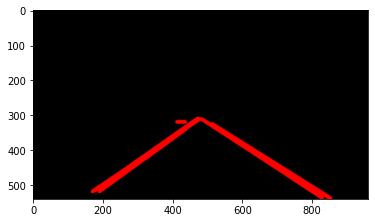

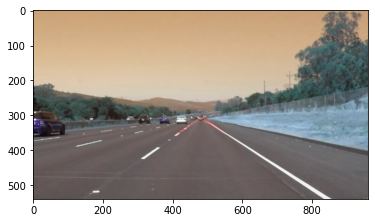

In [103]:
#TODO: overlap Hough lines on RGB input image - see overlap function defined last week
#params for overlap transparency
a = 0.8
b = 1
c = 0.

#code here
output=overlap(hough,a,image,b,c)
#print result
plt.imshow(output)

In [82]:
#TODO: add Hough lines to our_pipeline function defined last week
'''
def our_pipeline(image):
    
    ...//last week's code
    masked_edges = region_of_interest(canny_img)

    #Hough Transform Lines
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 20        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 180    # maximum gap in pixels between connectable line segments
    
    houghed_lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    a = 0.8
    b = 1
    c = 0.
    #Draw lines on image
    output = overlap(houghed_lines, a, image, b, c)

    return output
'''

"\ndef our_pipeline(image):\n    \n    ...//last week's code\n    masked_edges = region_of_interest(canny_img)\n\n    #Hough Transform Lines\n    rho = 1               # distance resolution in pixels of the Hough grid\n    theta = np.pi/180     # angular resolution in radians of the Hough grid\n    threshold = 20        # minimum number of votes (intersections in Hough grid cell)\n    min_line_length = 20  # minimum number of pixels making up a line\n    max_line_gap = 180    # maximum gap in pixels between connectable line segments\n    \n    houghed_lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)\n\n    a = 0.8\n    b = 1\n    c = 0.\n    #Draw lines on image\n    output = overlap(houghed_lines, a, image, b, c)\n\n    return output\n"

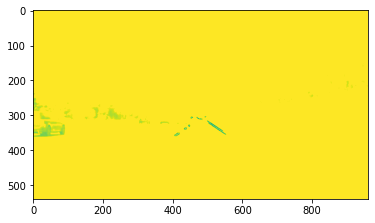

In [104]:
#TODO: apply updated pipeline - use our_pipeline
#code here
result=our_pipeline(image)


#and print result
#code here
plt.imshow(result)

At this point you should be here:
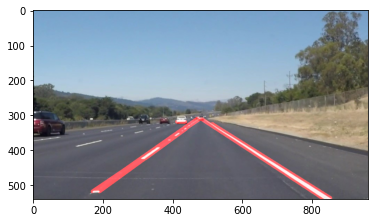

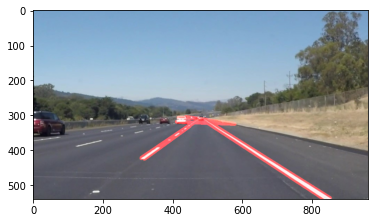

In [ ]:
#TODO: add image at https://drive.google.com/file/d/1ihgtG3GszspDfkVwmCgts3E-Zjvb7nAi/view?usp=sharing to My Drive

#TODO: adjust mask trapeze to fit the new lane
#bottom_left, top_left, top_right, bottom_right
'''
  bottom_left  = [0, rows*0.95]
  top_left     = [cols*0.45, rows*0.55]
  bottom_right = [cols, rows]
  top_right    = [cols*0.55, rows*0.55]
'''

#TODO: read new image - see cv2.imread
#code here

#TODO: BGR to RGB - see cv2.cvtColor(..., cv2.COLOR_BGR2RGB)
#code here

#TODO: apply updated pipeline
#code here

#TODO: print result - see plt.imshow
#code here


In [ ]:
#Apply new pipeline to video input
#TODO: add video at https://drive.google.com/file/d/1Eoag2llyOfiKNs-0d_9JQQXdb0a1HpVG/view?usp=sharing to My Drive

In [ ]:
# check for test video
!ls '/content/drive/My Drive/in.mp4'

In [ ]:
#some libraries needed for video manipulation and video display
!pip install moviepy

# needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
#make a copy of the input video
from shutil import copyfile
copyfile('/content/drive/My Drive/in.mp4', '/content/drive/My Drive/out.mp4')

In [ ]:
#needed to play .mp4 in Google Colab
!pip install -U kora
from kora.drive import upload_public
url = upload_public('/content/drive/My Drive/out.mp4')
# then display the original input video
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")

In [ ]:
white_output = '/content/drive/My Drive/out.mp4'
clip1 = VideoFileClip("/content/drive/My Drive/in.mp4")
white_clip = clip1.fl_image(our_pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

In [ ]:
url = upload_public(white_output)
# then display it
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")

Not finished yet! 

Multiple lines are confuzing.

In [ ]:
# this function calculates only one left line and one right line as a mean of the multiple left lines, respectively multiple right lines
# it uses the line equation with slope y = m*x + n to determine which are / and which \
# at the end the two lines are drawn on the input image

def slope_lines(image, lines):
    
    #copy input for result
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                #slope of a line crossing A(x1, y2), B(x2, y2)
                m = (y2 - y1) / (x2 - x1) 
                #we know that equation of line is y = m*x + n so we can write n = y - m*x
                n = y1 - m * x1

                if m < 0:
                    left_lines.append((m,n))
                elif m >= 0:
                    right_lines.append((m,n))

    #arithmetic mean to get only one (m, n) coefficients for left '/' and right '\' lines
    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #for both left & right lines compute the 2 points describing a line
    #the 2 segments are from the bottom to 60% of the height
    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +n so we can write it x=(y-n)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    #vertices of the two lines (looking like: / \ )
    poly_vertices = [poly_vertices[i] for i in order]

    #fill with color between left and right line
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))

    #overlap to original
    return overlap(image, 0.7, img, 0.4, 0.)

In [ ]:
#TODO: in function hough_lines replace draw_lines(line_img, lines)
# with line_img = slope_lines(line_img, lines)
# and execute hough_lines block to update function

In [ ]:
#TODO: execute blocks for 2nd test image (starting 10 blocks before this one)

This time instead of 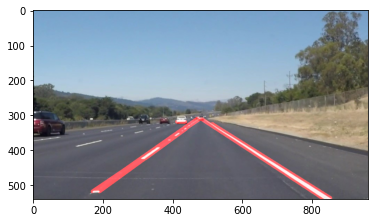 

you should be getting 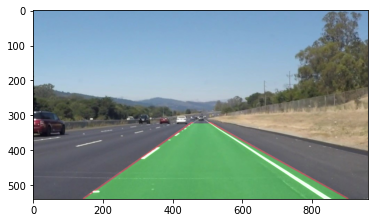

In [ ]:
#TODO: execute the code in order to apply updated pipeline to input video and display result